In [1]:
# Generally required modules
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
import sys


# grids
delta = 0.025
x = np.arange(-1, 1, delta)
y = np.arange(-1, 1, delta)
X, Y = np.meshgrid(x, y)

# parameters
barrier=4
#barrier=6

def pbc(x):
    """Brings x within -1 and 1"""
    return np.remainder(x+1,2)-1

def boundaries(x,y):
    """Boundaries are added to keep the system within -1,1 at the beginning of the simulation"""
    return (
         18*np.exp(-(pbc(y-1)/0.16)**2) +
         18*np.exp(-(pbc(x-1)/0.16)**2)
    )

def func1(x,y):
    """Most difficult function: CV does not distinguish R and P"""
    B= barrier*np.exp(- ((y)/0.3)**2)
    above=0.5*(1+np.sin(y*np.pi))
    below=1-above
    R=below* -7*np.exp(-(pbc(x+0.5)/0.4)**2 - (pbc(y+0.5)/0.4)**2)
    P=above* -9*np.exp(-(pbc(x+0.3)/0.8)**2 - (pbc(y-0.5)/0.4)**2)
    return (boundaries(x,y)+B+R+P)
   
def func2(x,y):
    """Intermediate case: CV distinguishes R and P but not TS"""
    B= barrier*np.exp(- ((y)/0.3)**2)
    above=0.5*(1+np.sin(y*np.pi))
    below=1-above
    R=below* -7*np.exp(-(pbc(x+0.5)/0.4)**2 - (pbc(y+0.5)/0.4)**2)
    P=above* -9*np.exp(-(pbc(x-0.7)/1.6)**2 - (pbc(y-0.5)/0.4)**2)
    return (boundaries(x,y)+B+R+P)

# Ideal case: CV distinguish R, P and TS
def func3(x,y):
    """Ideal case: CV distinguishes R, P and TS.
    
       Barrier on x is made 3x larger wrt func2
    """
    B= 2*barrier*np.exp(- ((x)/0.3)**2)
    above=0.5*(1+np.sin(y*np.pi))
    below=1-above
    R=below* -7*np.exp(-(pbc(x+0.5)/0.4)**2 - (pbc(y+0.5)/1)**2)
    P=above* -9*np.exp(-(pbc(x-0.5)/0.8)**2 - (pbc(y-0.5)/0.4)**2)
    #P=above* -9*np.exp(-(pbc(x-0.7)/1)**2 - (pbc(y-0.5)/0.4)**2)
    return (boundaries(x,y)+B+R+P)


In [2]:
def minimal_values(f):
    from scipy.optimize import minimize
    def ff(x):
        return f(x[0],x[1])
    res2 = minimize(ff, (0.5,0.5), method='SLSQP',bounds=((-1,1),(0,1))).fun
    res1 = minimize(ff, (-0.5,-0.5), method='SLSQP',bounds=((-1,1),(-1,0))).fun
    return res1,res2

In [3]:
# Run a simulation.

class run_results:
        def __init__(self):
            self.tt=[]
            self.xx=[]
            self.yy=[]
            self.ddv=[]
            self.ddvav=[]
            self.plotv=[]
            self.ddvref=[]
            self.v_R=[]
            self.v_P=[]
            self.vx=None
            self.v=[]
        def to_np(self):
            self.tt=np.array(self.tt)
            self.xx=np.array(self.xx)
            self.yy=np.array(self.yy)
            self.v=np.array(self.v)

    
def run(steps,func,height,bf=-1,plotstride=100,sigma=0.1,stride=100,save_v=False):
    """Run a simulation.
    
       You should specify the number of steps, the function (either func1 func2 or func3)
       and the height of the Gaussian. Optional parameters are biasfactor (default: non well-tempered),
       stride for plots, stride for Gaussians and width.
       
       It returns a class with a lot of outputs. To be documented.
    """
    import random
    import time
    results=run_results()
    random.seed(0)
    s1=-0.5
    s2=-0.5
    delta = 0.025
    x = np.arange(-1, 1, delta)
    y = np.arange(-1, 1, delta)
    nx=len(x)
    ny=len(y)
    X, Y = np.meshgrid(x, y)

    Z=func(x,Y)
    ref=-np.log(np.sum(np.exp(-Z),axis=0))
    results.ref=ref
    proj=ref*0

    is1=int((s1+1)/delta)
    is2=int((s2+1)/delta)
    start=time.time()
  
    # 1 = R
    # 2 = P
    laststate=0
    plotv=[ref-np.min(ref)]
    
    results.R_index=np.argmin(ref[0:int(len(ref)/2)])
    results.P_index=np.argmin(ref[int(len(ref)/2):])+int(len(ref)/2)
    
    for i in range(steps):
        # VERBOSE
        #if(i%(steps/100)==0):
        #    print("step",i,file=sys.stderr)
        (is1try,is2try)=(is1+random.randint(-2,2),is2+random.randint(-2,2))
        if(is1try>nx-1):
            is1try-=nx
        if(is1try<0):
            is1try+=nx
        if(is2try>ny-1):
            is2try-=ny
        if(is2try<0):
            is2try+=ny

        acc=np.exp(-(Z[is2try,is1try]+proj[is1try]-Z[is2,is1]-proj[is1]))
        if acc>random.uniform(0.0,1.0):
            (is1,is2)=(is1try,is2try)
        (s1,s2)=(-1+delta*is1,-1+delta*is2)

        # add hill
        if(i%stride==0):
            if bf>0:
                h=height*np.exp(-proj[is1]/(bf-1))
            else:
                h=height
            proj[:]+=h*np.exp(-0.5*(pbc(x[:]-s1)/sigma)**2)

        # plot
        if(i%plotstride==0):
            dv=-proj[results.R_index]+proj[results.P_index]
            dvref=ref[results.R_index]-ref[results.P_index]
            results.tt.append(i)
            results.xx.append(s1)
            results.yy.append(s2)
            results.ddv.append(dv)
            results.v_P.append(proj[results.P_index])
            results.v_R.append(proj[results.R_index])
            
            results.ddvref.append(dvref)
            if(s1<0 and s2<0):
                state=1 # R
            if(s1>0 and s2>0):
                state=2 # P
            if(laststate>0 and laststate != state):
                results.plotv.append(ref-np.min(ref)+proj)
            laststate=state
            if save_v:
                results.v.append(+proj)
                results.vx=x
                
    n=0
    s=0
    for i in range(len(results.ddv)):
        if i>0.2*len(results.ddv):
            s+=results.ddv[i]
            n=n+1
            results.ddvav.append(s/n)
        else:
            results.ddvav.append(0.0)
    results.to_np()
    return results
    
    # PLOT F+V at transitions:
#     plt.show()
#     for tr in plotv:
#         plt.plot(x,tr)
#     plt.show()
    #plt.plot(ddv)
    #plt.plot(ddvref)
    #plt.plot(ddvav)
    #plt.show()
    #print("Average:",np.average(ddv[int(0.2*len(ddv)):]),"ref:",np.average(ddvref))

In [4]:
def non_tempered_blocks(ddv,nb=5,lb=0):
    """Block analysis on non-well-tempered metad.
    
       ddv should be a numpy array with V(A)-V(B) at different times.
    """
    ave=[]
    if(lb!=0):
        nb=int(len(ddv)/lb)
    for ib in range(nb):
        ave.append(np.average(ddv[ib*int(len(ddv)/nb):(ib+1)*int(len(ddv)/nb)]))
    return np.average(ave),np.sqrt(np.var(ave)/(nb-1))

def tempered_blocks(v1,v2,bf,nb=5,lb=0):
    """Block analysis on well-tempered metad.
    
       v1 and v2 should be numpy arrays with V(A) and V(B) at different times.
    """
    ave=[]
    if(lb!=0):
        nb=int(len(v1)/lb)
    for ib in range(nb):
        i1=ib*int(len(v1)/nb)
        i2=(ib+1)*int(len(v1)/nb)-1
        ave.append(-np.log(
            (np.exp(v2[i2]/(bf-1))-np.exp(v2[i1]/(bf-1))+0.1) /
            (np.exp(v1[i2]/(bf-1))-np.exp(v1[i1]/(bf-1))+0.1)
        ))
    return np.average(ave),np.sqrt(np.var(ave)/(nb-1))

    

In [5]:
# runs
result1=run(func=func1,height=0.25,steps=100000,bf=-1,sigma=0.1,plotstride=5,save_v=True)
result2=run(func=func2,height=0.25,steps=100000,bf=-1,sigma=0.1,plotstride=5,save_v=True)
result3=run(func=func3,height=0.25,steps=100000,bf=-1,sigma=0.1,plotstride=5,save_v=True)
result1wt=run(func=func1,height=1,steps=100000,bf=10,sigma=0.1,plotstride=5,save_v=True)
result2wt=run(func=func2,height=1,steps=100000,bf=10,sigma=0.1,plotstride=5,save_v=True)
result3wt=run(func=func3,height=1,steps=100000,bf=10,sigma=0.1,plotstride=5,save_v=True)


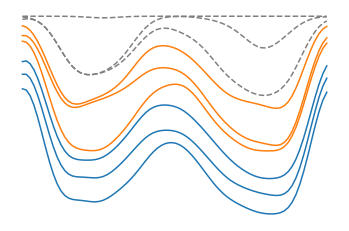

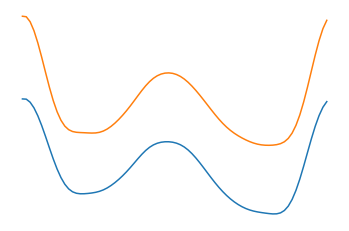

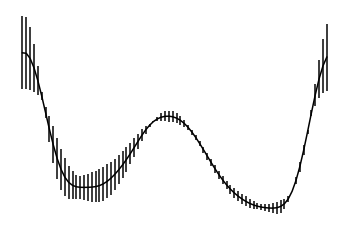

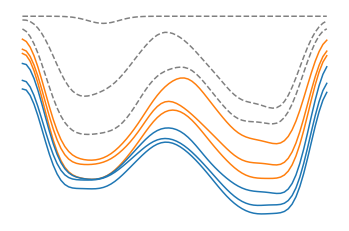

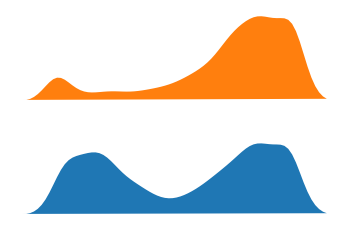

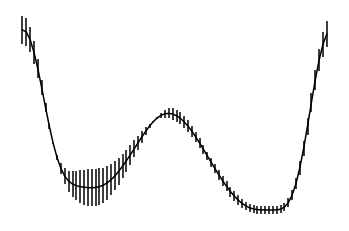

In [6]:
blue=u'#1f77b4'
orange=u'#ff7f0e'
green=u'#2ca02c'

a=result3.v[0:18000:2000]
bf=10
proj=-np.log(np.sum(np.exp(-func3(x,Y)),axis=0))

for i in range(len(a)):
    if(i<3): plt.plot(x,-(a[i]),"--",color="gray")
    elif(i<6): plt.plot(x,-(a[i]),color=orange)
    else: plt.plot(x,-(a[i]),color=blue)
plt.gca().set_xticklabels("")
plt.gca().set_yticklabels("")
plt.axis('off')

plt.savefig('eo1.png',dpi=300)

plt.show()

ave=[]

ave.append(np.average(result3.v[6000:12000,:],axis=0))
ave.append(np.average(result3.v[12000:18000,:],axis=0))

ave=np.array(ave)

for i in range(len(ave)):
    ave[i]-=np.average(ave[i])
    plt.plot(x,-ave[i]+10*i)

plt.gca().set_xticklabels("")
plt.gca().set_yticklabels("")
plt.axis('off')

plt.savefig('eo2.png',dpi=300)
plt.show()


estimate=np.average(-ave,axis=0)
estimate-=np.min(estimate)

plt.errorbar(x,estimate,np.std(ave,axis=0)/np.sqrt(2.0) * 5,color="black")
#plt.plot(x,proj-np.min(proj))
#plt.ylim(-1,7)
plt.gca().set_xticklabels("")
plt.gca().set_yticklabels("")
plt.axis('off')

plt.savefig('eo3.png',dpi=300)
plt.show()

a=result3wt.v[0:18000:2000]

for i in range(len(a)):
    if(i<3): plt.plot(x,-bf/(bf-1)*(a[i]),"--",color="gray")
    elif(i<6): plt.plot(x,-bf/(bf-1)*(a[i]),color=orange)
    else: plt.plot(x,-bf/(bf-1)*(a[i]),color=blue)
plt.gca().set_xticklabels("")
plt.gca().set_yticklabels("")
plt.axis('off')

plt.savefig('ew1.png',dpi=300)
plt.show()

h=[]
h.append(np.exp(a[5]/(bf-1))-np.exp(a[2]/(bf-1)))
h.append(np.exp(a[8]/(bf-1))-np.exp(a[5]/(bf-1)))

h=np.array(h)
hh=np.zeros((h.shape[0],h.shape[1]+1))
hh[:,0:-1]=h[:]
hh[:,-1]=hh[:,0]
xx=np.zeros(x.shape[0]+1)
xx[-1]=x[0]
xx[0:-1]=x
plt.fill(xx,hh[0])
plt.fill(xx,hh[1]+10)

plt.gca().set_xticklabels("")
plt.gca().set_yticklabels("")
plt.axis('off')
plt.savefig('ew2.png',dpi=300)

plt.show()

estimate=-np.average(a[5:20],axis=0)*bf/(bf-1)
estimate-=np.min(estimate)

plt.errorbar(x,estimate,np.std(np.log(h),axis=0)/np.sqrt(2.0)*5,color="black")
#plt.plot(x,proj-np.min(proj))
#plt.ylim(-1,7)
plt.gca().set_xticklabels("")
plt.gca().set_yticklabels("")
plt.axis('off')
plt.savefig('ew3.png',dpi=300)

plt.show()




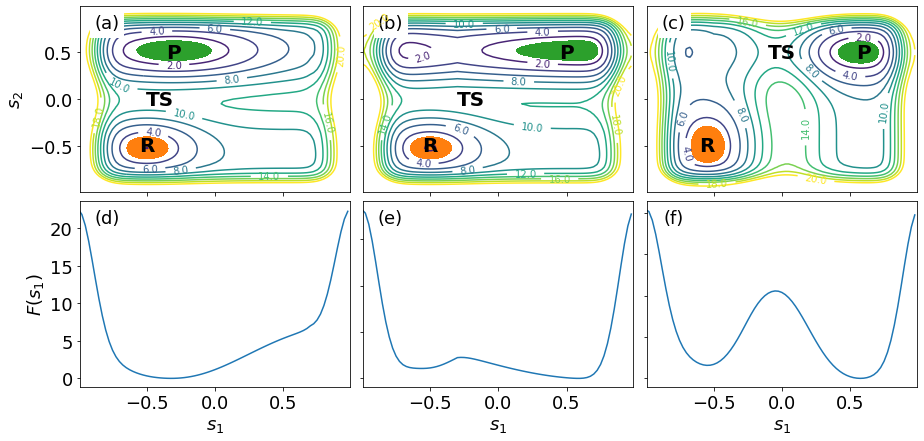

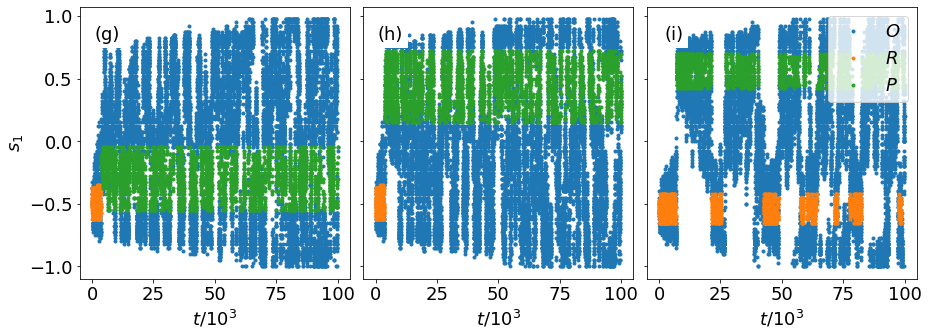

In [10]:
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
matplotlib.rc('font', size=18) 


if True:
    fig, ax = plt.subplots(2,3,figsize=(15,7),sharex=True)


    def plot(ax,X,Y,Z,x,minima):
#        setR=np.logical_and((func3(result3.xx,result3.yy)-minimal_values(func3)[0])<1,result3.yy<0)

        CS=ax[0].contour(X,Y,Z-np.min(Z),levels=np.linspace(0,20,11))
        ax[0].clabel(CS,inline=1, fontsize=10,fmt="%2.1f")
        #[u'#1f77b4', u'#ff7f0e', u'#2ca02c'
        ax[0].contourf(X[int(X.shape[0]/2):,:],Y[int(Y.shape[0]/2):,:],(Z-minima[1])[int(Z.shape[0]/2):,:],levels=[0,1],colors=[u'#2ca02c'])
        ax[0].contourf(X[:int(X.shape[0]/2),:],Y[:int(Y.shape[0]/2),:],(Z-minima[0])[:int(Z.shape[0]/2),:],levels=[0,1],colors=[u'#ff7f0e'])
        ax[0].set_ylabel("$s_2$")
        ax[1].set_ylabel("$F(s_1)$")
        #ax[2].set_ylabel("$s_2$")
        #ax[2].set_xlabel("$s_1$")
        proj=-np.log(np.sum(np.exp(-Z),axis=0))
        ax[1].plot(x,proj-np.min(proj))
        Zb=Z.copy()
        for i in Zb:
            i-=proj[:]
        #CS = ax[2].contour(X, Y, Zb-np.min(Zb))
        #ax[2].clabel(CS, inline=1, fontsize=10,fmt="%2.1f")

    # plot((ax[0,0],ax[1,0],ax[2,0]),X,Y,func1(x,Y),x)
    # plot((ax[0,1],ax[1,1],ax[2,1]),X,Y,func2(x,Y),x)
    # plot((ax[0,2],ax[1,2],ax[2,2]),X,Y,func3(x,Y),x)

    plot((ax[0,0],ax[1,0]),X,Y,func1(x,Y),x,minimal_values(func1))
    plot((ax[0,1],ax[1,1]),X,Y,func2(x,Y),x,minimal_values(func2))
    plot((ax[0,2],ax[1,2]),X,Y,func3(x,Y),x,minimal_values(func3))

    for i in ax[:,1]:
        i.set_ylabel("")
        i.set_yticklabels("")
    for i in ax[:,2]:
        i.set_ylabel("")
        i.set_yticklabels("")

    for i in ax[0,:]:
        i.set_xlim([-0.99,0.99])
        i.set_ylim([-0.99,0.99])

    for i in ax[1,:]:
        i.set_xlim([-0.99,0.99])
        i.set_xlabel("$s_1$")
        # i.set_ylim([-0.99,0.99])

    # for i in ax[2,:]:
    #     i.set_xlim([-0.99,0.99])
    #     i.set_ylim([-0.99,0.99])
    #     i.set_xlabel("$s_1$")
    # ax[2,0].set_ylabel("$s_2$")




    ax[0,0].text(0.1,0.88,"(a)",transform=ax[0,0].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
    ax[0,1].text(0.1,0.88,"(b)",transform=ax[0,1].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
    ax[0,2].text(0.1,0.88,"(c)",transform=ax[0,2].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")

    ax[1,0].text(0.1,0.88,"(d)",transform=ax[1,0].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
    ax[1,1].text(0.1,0.88,"(e)",transform=ax[1,1].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
    ax[1,2].text(0.1,0.88,"(f)",transform=ax[1,2].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")

    # ax[2,0].text(0.1,0.88,"(g)",transform=ax[2,0].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
    # ax[2,1].text(0.1,0.88,"(h)",transform=ax[2,1].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
    # ax[2,2].text(0.1,0.88,"(i)",transform=ax[2,2].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")

    ax[0,0].text(-0.5,-0.5,"R",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")
    ax[0,0].text(-0.3,0.5,"P",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")
    ax[0,0].text(-0.4,0,"TS",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")

    ax[0,1].text(-0.5,-0.5,"R",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")
    ax[0,1].text(0.5,0.5,"P",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")
    ax[0,1].text(-0.2,0.0,"TS",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")

    ax[0,2].text(-0.55,-0.5,"R",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")
    ax[0,2].text(0.6,0.5,"P",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")
    ax[0,2].text(0,0.5,"TS",horizontalalignment='center',verticalalignment='center',fontweight='bold',fontsize="20")

# ax[2,:].set_xlabel("")

# ax[2,0].plot(result1.xx,result1.yy,'.',markersize=4)
# ax[2,1].plot(result2.xx,result2.yy,'.',markersize=4)
# ax[2,2].plot(result3.xx,result3.yy,'.',markersize=4)

    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    plt.savefig('fig1a.png',dpi=300)
    plt.savefig('fig1a.svg')

#plt.show()



fig, ax = plt.subplots(1,3,figsize=(15,5))
# tt=[]
# xx=[]
# yy=[]
# ## UNCOMMENT
# ax[0].plot(result2.xx,result2.yy,'.',markersize=4)
# ax[0].set_xlim([-0.99,0.99])
# ax[0].set_ylim([-0.99,0.99])
# ax[1].plot(np.array(result2.tt)/1000,result2.xx,label="$s_1$",linewidth=1)
# ax[1].plot(np.array(result2.tt)/1000,result2.yy,label="$s_2$",linewidth=1)
# ax[1].set_ylim([-0.99,0.99])

# tt=[]
# xx=[]
# yy=[]

## UNCOMMENT

# ax[0].plot(np.array(result1.tt)/1000,result1.xx,label="$s_1$",linewidth=1)
# ax[0].plot(np.array(result1.tt)/1000,result1.yy,label="$s_2$",linewidth=1)
# ax[1].plot(np.array(result2.tt)/1000,result2.xx,label="$s_1$",linewidth=1)
# ax[1].plot(np.array(result2.tt)/1000,result2.yy,label="$s_2$",linewidth=1)
# ax[2].plot(np.array(result3.tt)/1000,result3.xx,label="$s_1$",linewidth=1)
# ax[2].plot(np.array(result3.tt)/1000,result3.yy,label="$s_2$",linewidth=1)
#ax[0].set_xlabel("$s_1$")

setR=np.logical_and((func1(result1.xx,result1.yy)-minimal_values(func1)[0])<1,result1.yy<0)
setP=np.logical_and((func1(result1.xx,result1.yy)-minimal_values(func1)[1])<1,result1.yy>0)
setO=np.logical_not(np.logical_or(setR,setP))

ax[0].plot((result1.tt/1000)[setO],result1.xx[setO],".",label="O")
ax[0].plot((result1.tt/1000)[setR],result1.xx[setR],".",label="R")
ax[0].plot((result1.tt/1000)[setP],result1.xx[setP],".",label="P")


setR=np.logical_and((func2(result2.xx,result2.yy)-minimal_values(func2)[0])<1,result2.yy<0)
setP=np.logical_and((func2(result2.xx,result2.yy)-minimal_values(func2)[1])<1,result2.yy>0)
setO=np.logical_not(np.logical_or(setR,setP))

ax[1].plot((result2.tt/1000)[setO],result2.xx[setO],".",label="O")
ax[1].plot((result2.tt/1000)[setR],result2.xx[setR],".",label="R")
ax[1].plot((result2.tt/1000)[setP],result2.xx[setP],".",label="P")


#ax[2].plot((result3.tt/1000)[(result3.xx<0) & (result3.yy>0)],result3.xx[(result3.xx<0) & (result3.yy>0)],".",label="R2")
#ax[2].plot((result3.tt/1000)[(result3.xx<0) & (result3.yy<0)],result3.xx[(result3.xx<0) & (result3.yy<0)],".",label="R")
#ax[2].plot((result3.tt/1000)[result3.xx>0],result3.xx[result3.xx>0],".",label="P")

setR=np.logical_and((func3(result3.xx,result3.yy)-minimal_values(func3)[0])<1,result3.yy<0)
setP=np.logical_and((func3(result3.xx,result3.yy)-minimal_values(func3)[1])<1,result3.yy>0)
setO=np.logical_not(np.logical_or(setR,setP))

ax[2].plot((result3.tt/1000)[setO],result3.xx[setO],".",label="$O$")
ax[2].plot((result3.tt/1000)[setR],result3.xx[setR],".",label="$R$")
ax[2].plot((result3.tt/1000)[setP],result3.xx[setP],".",label="$P$")


ax[0].set_xlabel("$t/10^{3}$")
ax[1].set_xlabel("$t/10^{3}$")
ax[2].set_xlabel("$t/10^{3}$")
ax[0].set_ylabel("$s_1$")
ax[1].set_yticklabels("")
ax[2].set_yticklabels("")


ax[0].text(0.1,0.88,"(g)",transform=ax[0].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
ax[1].text(0.1,0.88,"(h)",transform=ax[1].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
ax[2].text(0.1,0.88,"(i)",transform=ax[2].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
ax[2].legend(loc="upper right")
#ax[1,0].text(0.1,0.88,"(n)",transform=ax[1,0].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
#ax[1,1].text(0.1,0.88,"(o)",transform=ax[1,1].transAxes,horizontalalignment='center',backgroundcolor='white',fontsize="18")
#ax[1,1].legend(loc="upper right")

fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('fig1b.png',dpi=300)
plt.savefig('fig1b.svg')
plt.show()


In [9]:
plt.savefig('test.png',dpi=300)

<Figure size 432x288 with 0 Axes>

**Tentative caption**.
Sample free-energy landscapes in cases where the chosen CV cannot distinguish reactant (R) and product (P) (panel (a)), cannot distinguish the transition state (TS) from R (panel (b)), and can distinguish R, P and TS (panel (c)).
Free energies $F(s_1,s_2)$ are shown as functions of two CVs ($s_1$ and $s_2$) using contour lines. $s_1$ represents the chosen (biased) CV. Corresponding projections $F(s_1)$ are shown in panels (d), (e), and (f).
Residual free-energy profiles $F(s_1,s_2)-F(s_1)$ are shown in panels (g), (h), and (i) and report the barrier that a system would have to overcome in the ideal case where a bias potential exactly cancelling the free-energy profile would be added. Sample trajectories using metadynamics are reported both in the $s_1$,$s_2$ space and as a function of time. Panels (l) and (m) correspond to the free energy in (b). Here a single transition is observed going from R to P. Panels (n) and (o) correspond to the free energy in (c). Multiple transitions are observed in this case.

# TESTS

In [20]:
non_tempered2=run(func=func2,height=0.25,steps=100000,bf=-1,sigma=0.1,stride=100)
#pickle.dump(non_tempered2,open("b-non_tempered2","wb"))
non_tempered3=run(func=func3,height=0.25,steps=100000,bf=-1,sigma=0.1,stride=100)
#pickle.dump(non_tempered3,open("b-non_tempered3","wb"))

tempered2=run(func=func2,height=1,steps=100000,bf=10,sigma=0.1,stride=100)
#pickle.dump(non_tempered2,open("b-tempered2","wb"))
tempered3=run(func=func3,height=1,steps=100000,bf=10,sigma=0.1,stride=100)
#pickle.dump(non_tempered3,open("b-tempered3","wb"))

# saved with steps=100000000
#non_tempered2=pickle.load(open("b-non_tempered2","rb"))
#non_tempered3=pickle.load(open("b-non_tempered3","rb"))
#tempered2=pickle.load(open("b-tempered2","rb"))
#tempered3=pickle.load(open("b-tempered3","rb"))

In [32]:
def ana_tempered(ana):
    plt.plot(np.array(ana.ddv)*10/9)

    plt.plot(np.array(ana.ddvav)*10/9)
    plt.plot(ana.ddvref)
    plt.show()

    plt.plot(ana.yy,'ro')
    plt.show()

    print("Reference:",ana.ddvref[-1])
    print("Final: ",ana.ddv[-1]*10/9)
    print("Estimate: ",ana.ddvav[-1]*10/9)

    print("Block analysis")
    plotx=[]
    ploty=[]
    tail_P=np.array(ana.v_P)[int(len(ana.v_P)/5):]
    tail_R=np.array(ana.v_R)[int(len(ana.v_R)/5):]
    lb=1
    err=[]
    while lb*3<len(tail_P):
        lb=max(lb+1,int(lb*1.2))
        plotx.append(lb)
        ploty.append(tempered_blocks(tail_P,tail_R,10,lb=lb)[1])
    plt.semilogx(plotx,ploty)
    print("Error: ",np.max(ploty))
    print("Transition count:",len(ana.plotv))
    
def ana_nontempered(ana):
    plt.plot(np.array(ana.ddv))

    plt.plot(np.array(ana.ddvav))
    plt.plot(ana.ddvref)
    plt.show()

    plt.plot(ana.yy,'ro')
    plt.show()

    print("Reference:",ana.ddvref[-1])
    print("Estimate: ",ana.ddvav[-1])

    print("Block analysis")
    plotx=[]
    ploty=[]
    tail=np.array(ana.ddv)[int(len(ana.ddv)/5):]
    lb=1
    err=[]
    while lb*3<len(ana.ddv):
        lb=max(lb+1,int(lb*1.2))
        plotx.append(lb)
        ploty.append(non_tempered_blocks(tail,lb=lb)[1])
    print("Average: ",np.average(tail))
    plt.semilogx(plotx,ploty)
    print("Error: ",np.max(ploty))
    print("Transition count:",len(ana.plotv))

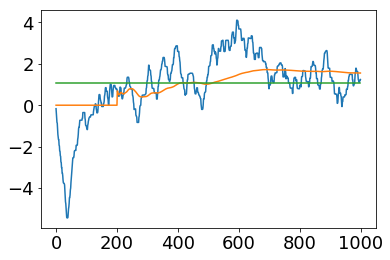

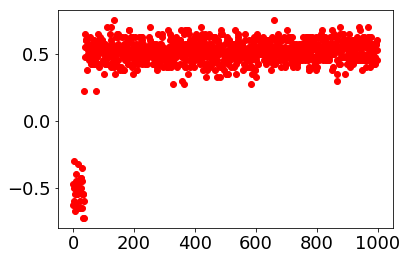

Reference: 1.0703026737470989
Final:  1.240839726756404
Estimate:  1.5527451154020702
Block analysis
Error:  0.249623142849791
Transition count: 1


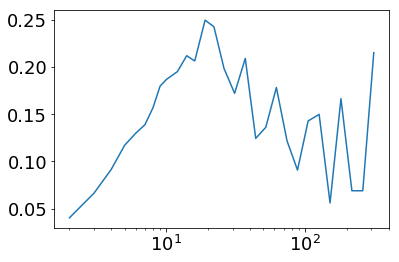

In [33]:
ana_tempered(non_tempered2)

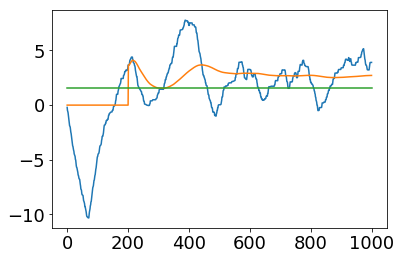

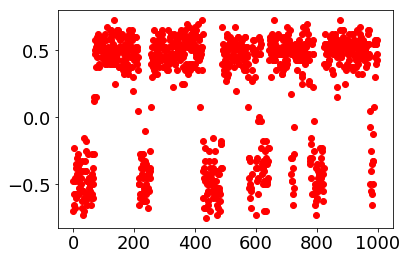

Reference: 1.5699756565177267
Final:  3.9068052425150057
Estimate:  2.7163918340255777
Block analysis
Error:  0.5641299329784017
Transition count: 19


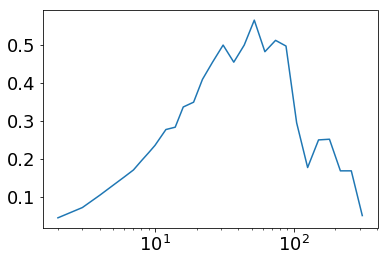

In [34]:
ana_tempered(non_tempered3)

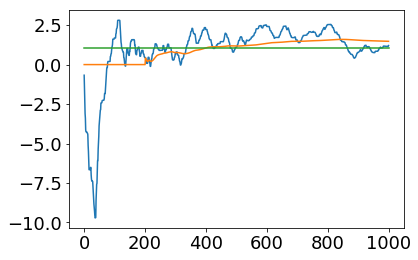

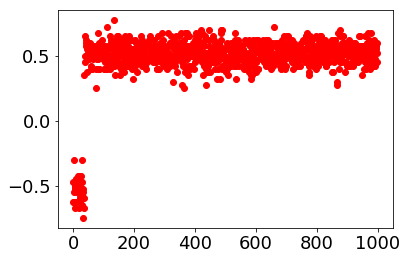

Reference: 1.0703026737470989
Final:  1.2049822648465043
Estimate:  1.4740621731157157
Block analysis
Error:  0.3171866108771577
Transition count: 1


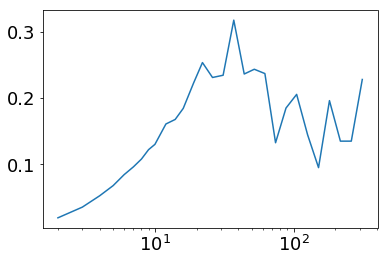

In [35]:
ana_tempered(tempered2)

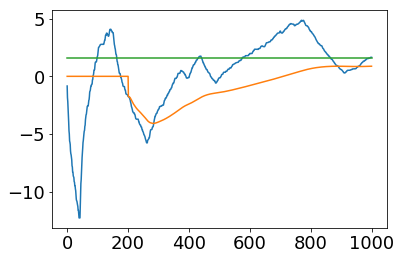

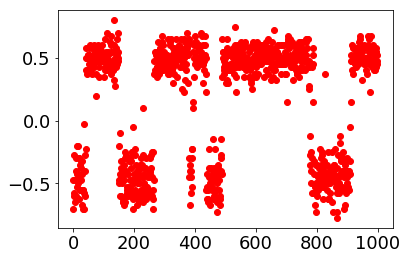

Reference: 1.5699756565177267
Final:  1.646597792446707
Estimate:  0.8763686559795353
Block analysis
Error:  0.7737425242193341
Transition count: 11


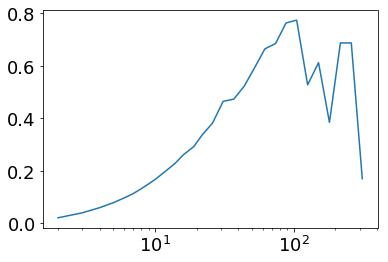

In [37]:
ana_tempered(tempered3)

In [38]:
# long_non_tempered2=run(func=func2,height=0.25,steps=100000000,bf=-1,sigma=0.1,stride=100)
# pickle.dump(long_non_tempered2,open("b-non_tempered2","wb"))
# long_non_tempered3=run(func=func3,height=0.25,steps=100000000,bf=-1,sigma=0.1,stride=100)
# pickle.dump(long_non_tempered3,open("b-non_tempered3","wb"))

# long_tempered2=run(func=func2,height=1,steps=100000000,bf=10,sigma=0.1,stride=100)
# pickle.dump(long_tempered2,open("b-tempered2","wb"))
# long_tempered3=run(func=func3,height=1,steps=100000000,bf=10,sigma=0.1,stride=100)
# pickle.dump(long_tempered3,open("b-tempered3","wb"))

# saved with steps=100000000
long_non_tempered2=pickle.load(open("b-non_tempered2","rb"))
ong_non_tempered3=pickle.load(open("b-non_tempered3","rb"))
long_tempered2=pickle.load(open("b-tempered2","rb"))
long_tempered3=pickle.load(open("b-tempered3","rb"))

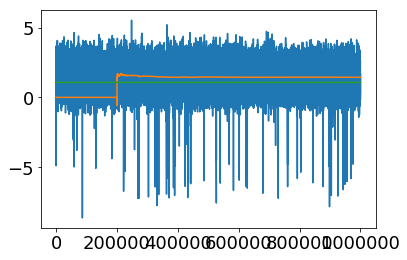

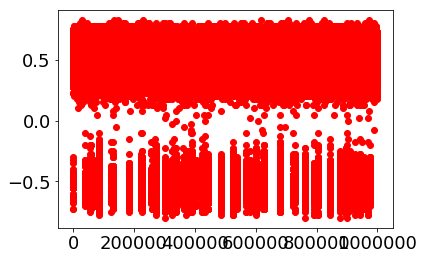

Reference: 1.0703026737470989
Estimate:  1.439480459252347
Block analysis
Average:  1.4394781394162375
Error:  0.017977999951548654
Transition count: 119


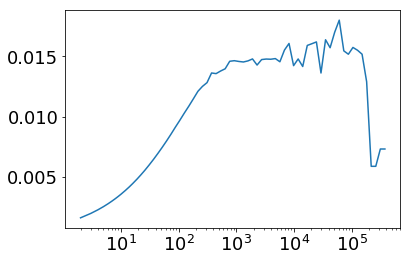

In [39]:
ana_nontempered(long_non_tempered2)

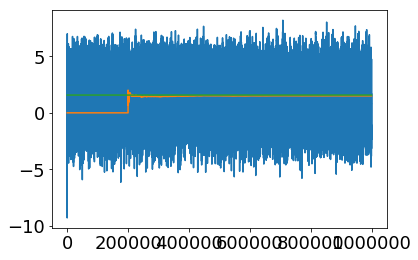

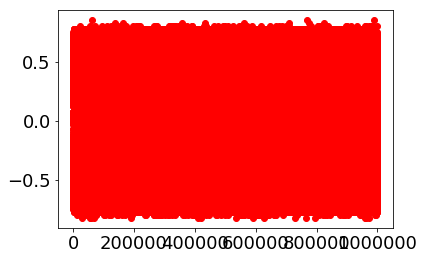

Reference: 1.5699756565177267
Estimate:  1.498535657488445
Block analysis
Average:  1.4985341987192717
Error:  0.020771021789733453
Transition count: 18469


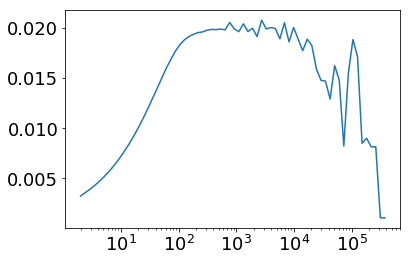

In [40]:
ana_nontempered(long_non_tempered3)

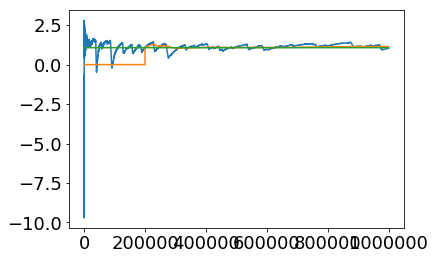

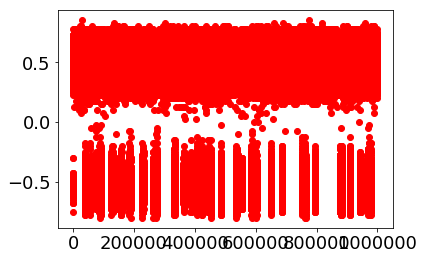

Reference: 1.0703026737470989
Final:  1.0292233894513774
Estimate:  1.1424238792319428
Block analysis
Error:  0.0907721629766954
Transition count: 83


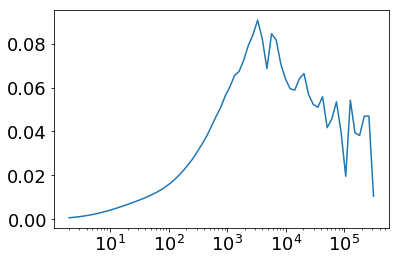

In [41]:
ana_tempered(long_tempered2)

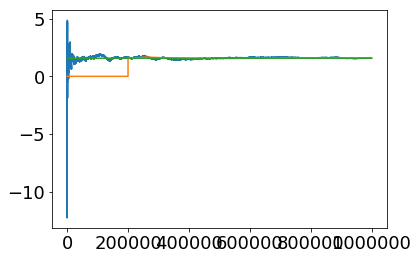

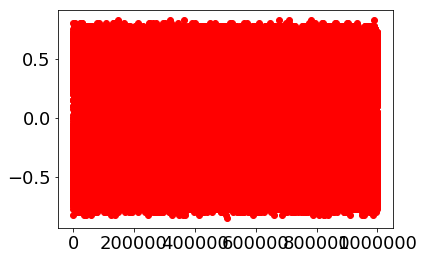

Reference: 1.5699756565177267
Final:  1.5661128229487058
Estimate:  1.5906049992431164
Block analysis
Error:  0.029875388071485466
Transition count: 9864


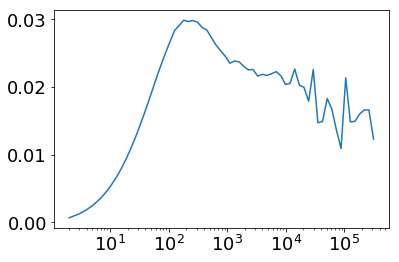

In [42]:
ana_tempered(long_tempered3)